# MEng-Team-Project-ML

This notebook contains the initial analysis of JSON files generated \
by our ML system as of December 2022 (refer to git commit for exact \
version).

Each one of our key objectives is potentially non-trivial to implement. \
The issues with each objective are listed below: 
- Object Identification 
  - This objective is the easiest to implement as we have the predicted \
    object along with it's bounding box per frame. However, across different \
    frames the object and camera can experience different scenarios which \
    can make relying on any individual frame invalid. For example, the \
    `00001.01350_2022-12-07T15-35-24.000Z.mp4` test file in the daytime \
    dataset on Google Drive shows the bus which is driving away from the \
    camera as being misidentified as a truck closer towards the middle / \
    end of the video. This is a common theme throughout the TFL JamCam \
    datasets. One way to rectify this, is to take the object predictions across \
    the entire time the object is in view (by taking it's predicted anchor value) \
    and determining the mode of the predicted classes. This is likely to be correct \
    for nice scenarios (day time, no glare). This needs to be deliberated further \
    for harder conditions such as night time / snow, etc.
- Object Count
  - For this objective, although it may appear simple on the surface, is \
    actually non-trivial because we have to correctly count the number of \
    objects across a time period. This becomes difficult for two reasons, \
    firstly we have to correctly identify the same object moving across \
    the field of view which can be problematic if the object is momentarily \
    obscured for whatever reason (e.g. camera blur, goes out of view and then \
    back into view. For example in our case, an object could cross from one exit \
    onto another exit in the Bunarby Road junction but be blocked by a HGV vehicle. \
    This would now count as a new object which would affect our counting of the objects). \
    The second issue is if the object is momentarily miscategorised which means that \
    yolov7's default method of tracking the object considers it a different object.
- Object Tracking
  - Similar to the above issue, object tracking relies on being able to identify the object \
    you are tracking as the same object across different frames. If an object is misidentified \
    partially before the video ends or the object exits the frame, this can cause the object \
    tracker to treat the object which was already being tracked as a new object. In theory, \
    we could implement code to see where a route / object was already being tracked and treat \
    it as the same object if it is reasonably close to what was being tracked before. This requires \
    testing / experimenting / tweaking. It is likely we can get a solution which is good enough \
    but I don't think we can straight up solve this issue as it has complex, non-trivial edge cases.

## Load Dataset

### Load COCO Classes

In [1]:
import yaml

COCO_YAML_PATH = "../yolov7-segmentation/data/coco.yaml"

def load_coco_classes(coco_settings):
    with open(coco_settings, "r") as stream:
        try:
            coco_data = yaml.safe_load(stream)
            coco_data = coco_data["names"]
            return coco_data
        except yaml.YAMLError as exc:
            print(exc)

COCO_CLASSES = load_coco_classes(COCO_YAML_PATH)

### Load Pre-Saved Analytical Dataset

In [2]:
import os
dataset_dir = \
    "C:/Users/win8t/OneDrive/Desktop/projects/" + \
    "MEng-Team-Project-ML/yolov7-segmentation/runs/predict-seg/exp/labels"
fis       = os.listdir(dataset_dir)
fis.sort(key=len)
info_fis    = [fi for fi in fis if "_info" in fi]
track_fis   = [fi for fi in fis if "_track" in fi]
other_fis   = [fi for fi in fis if not "_track" in fi and not "_info" in fi]
frame_count = max([int(fi.split("_")[-1].split(".json")[0]) for fi in other_fis])
print("len(info_fis), len(track_fis), len(other_fis):", len(info_fis), len(track_fis), len(other_fis))
frame_count

len(info_fis), len(track_fis), len(other_fis): 261 261 261


261

In [3]:
import json

def load_frame(frame):
    # frame += 1
    
    get_frame   = lambda i: (info_fis[i], track_fis[i], other_fis[i])
    first_frame = get_frame(frame)
    
    # print(os.path.join(dataset_dir, first_frame[0]))
    with open(os.path.join(dataset_dir, first_frame[0])) as f:
        first_frame_info = json.loads(f.read())["infos"]

    # print(os.path.join(dataset_dir, first_frame[1]))
    with open(os.path.join(dataset_dir, first_frame[1])) as f:
        first_frame_tracks = json.loads(f.read())["routes"]

    # print(os.path.join(dataset_dir, first_frame[2]))
    with open(os.path.join(dataset_dir, first_frame[2])) as f:
        lines = f.read().split("\n")
        lines = list(filter(None, lines))
        content = "[" + ",".join(lines) + "]"
        first_frame_base = json.loads(content)
    
    return first_frame_info, first_frame_tracks, first_frame_base

In [4]:
frames = []
for cur_frame in range(frame_count):
    frames.append(load_frame(cur_frame))
print("len(frames):", len(frames))

len(frames): 261


## Data Analysis

### Recorded Info Count (per Frame)

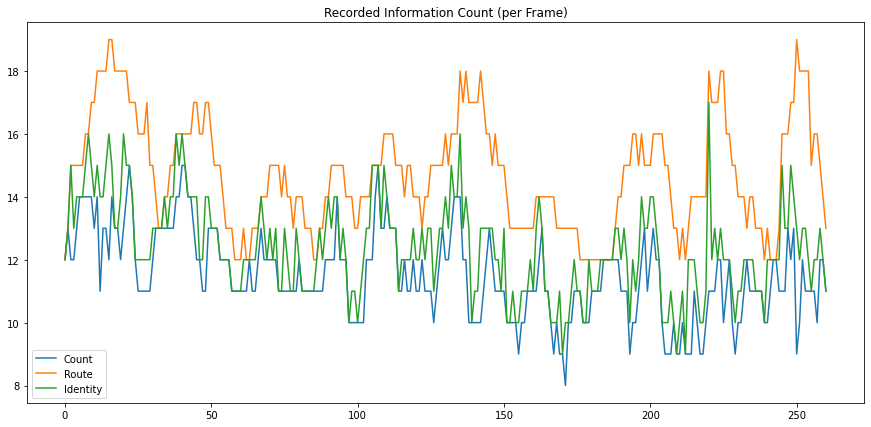

In [5]:
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (15,7)

# NOTE: The format of frames := [(info, tracks, base) * frame_count]
infos  = [frame[0] for frame in frames]
tracks = [frame[1] for frame in frames]
bases  = [frame[2] for frame in frames]

info_counts  = [len(frame[0]) for frame in frames]
track_counts = [len(frame[1]) for frame in frames]
base_counts  = [len(frame[2]) for frame in frames]

plt.title("Recorded Information Count (per Frame)")
plt.plot(info_counts,  label="Count")
plt.plot(track_counts, label="Route")
plt.plot(base_counts,  label="Identity")
plt.legend()

### Identify Objects in Each Scene

#### Construct Base and Info DataFrames

In [6]:
import pandas as pd

flatten = lambda lst: [item for sublist in lst for item in sublist]

# Desired classes
target_classes = ["bicycle", "car", "bus", "truck", "person"]
target_idxs    = [COCO_CLASSES.index(target_class)
                  for target_class in target_classes]

def gen_df(rows, cols):
    # Construct base data frame
    print(cols, rows[0])
    df_rows = flatten([[{"frame": i+1} | row for row in rows]
                        for i, rows in enumerate(bases)])
    df_cols = cols
    new_df = pd.DataFrame(df_rows, columns=df_cols) # (3228 rows × 7 columns)
    return new_df

def gen_base_df(bases):
    # Construct base data frame
    base_rows = flatten([[{"frame": i+1} | row for row in rows]
                        for i, rows in enumerate(bases)])
    base_cols = ["frame", "class", "x1", "y1", "x2", "y2", "conf"]
    base_df   = gen_df(base_rows, base_cols)

    # Filter df to only contain target classes
    base_df = base_df[base_df["class"].isin(target_idxs)]  # (3160 rows × 7 columns)

    # Add a column containing class label (instead of just class idx)
    base_df["label"] = base_df["class"].apply(lambda row: COCO_CLASSES[int(row)])
    return base_df

def gen_info_df(infos):
    info_rows = []
    for i, rows in enumerate(infos):
        for row in rows:
            cur = {
                "frame":     i+1,
                "bbox_x1":   row["bbox"]["x1"],
                "bbox_y1":   row["bbox"]["y1"],
                "bbox_x2":   row["bbox"]["x2"],
                "bbox_y2":   row["bbox"]["y2"],
                "label":     row["label"],
                "anchor_x":  row["anchor"]["x"],
                "anchor_y":  row["anchor"]["y"]
            }
            info_rows.append(cur)

    info_cols = [
        "frame",
        "bbox_x1",
        "bbox_y1",
        "bbox_x2",
        "bbox_y2",
        "label",
        "anchor_x",
        "anchor_y"]
    
    info_df = pd.DataFrame(info_rows, columns=info_cols)

    return info_df

def gen_route_df(data):
    route_rows = []

    routes_s = data
    for i in range(0, 10): # len(data)): # frames
        for routes in routes_s:
            for j, route in enumerate(routes):
                print("frame:", i, "route:", j)
                cur = [{
                            "frame": i+1,
                            "route": j+1,
                            "x1": subroute["x1"],
                            "y1": subroute["y1"],
                            "x2": subroute["x2"],
                            "y2": subroute["y2"]
                        }
                        for subroute in route]
                route_rows.append(cur)
                
    route_cols = ["frame", "route", "x1", "y1", "x2", "y2"]

    route_df = pd.DataFrame(route_rows, columns=route_cols)
    return route_df
    
base_df  = gen_base_df(bases)
info_df  = gen_info_df(infos)
track_df = gen_route_df(tracks)
# base_df, info_df
track_df

['frame', 'class', 'x1', 'y1', 'x2', 'y2', 'conf'] {'frame': 1, 'class': 0.0, 'x1': 1.0, 'y1': 176.0, 'x2': 10.0, 'y2': 204.0, 'conf': 0.36181640625}
frame: 0 route: 0
frame: 0 route: 1
frame: 0 route: 2
frame: 0 route: 3
frame: 0 route: 4
frame: 0 route: 5
frame: 0 route: 6
frame: 0 route: 7
frame: 0 route: 8
frame: 0 route: 9
frame: 0 route: 10
frame: 0 route: 11
frame: 0 route: 0
frame: 0 route: 1
frame: 0 route: 2
frame: 0 route: 3
frame: 0 route: 4
frame: 0 route: 5
frame: 0 route: 6
frame: 0 route: 7
frame: 0 route: 8
frame: 0 route: 9
frame: 0 route: 10
frame: 0 route: 11
frame: 0 route: 12
frame: 0 route: 0
frame: 0 route: 1
frame: 0 route: 2
frame: 0 route: 3
frame: 0 route: 4
frame: 0 route: 5
frame: 0 route: 6
frame: 0 route: 7
frame: 0 route: 8
frame: 0 route: 9
frame: 0 route: 10
frame: 0 route: 11
frame: 0 route: 12
frame: 0 route: 13
frame: 0 route: 14
frame: 0 route: 0
frame: 0 route: 1
frame: 0 route: 2
frame: 0 route: 3
frame: 0 route: 4
frame: 0 route: 5
frame: 0 rou

KeyboardInterrupt: 

In [ ]:
track_df

### Count Objects in Each Scene

#### (Naive) Count Objects in Each Scene

Take a naive count of each object in the scene by counting the labels across all frames. \
Ignores many fundamental issues but provided to illustrate the point. \
If you are using the analytical data for the `00001.01350_2022-12-07T15-35-24.000Z` \
video, you will see the following value counts:

| object | count |
| --- | --- |
| person | 1525 |
| car | 1275 |
| bus | 208 |
| truck | 102 |
| bicycle | 50 |

Obviously across a 10 second day time snippet of a junction in London, \
there was not 1,525 people detected. Clearly we need a more \
sophisticated way of counting people.

In [7]:
base_df["label"].value_counts()

person     1525
car        1275
bus         208
truck       102
bicycle      50
Name: label, dtype: int64